In [4]:
# Install Java, Spark, and Findspark
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu 

In [5]:
# I have yelp 100k dataset loaded into my google drive
# this allows me to access that data from inside spark
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g7hlZsfCpFKGK667bzz_4jL7vBmfXiQCkukNcm6QiI-O4110tqG8UI
Mounted at /content/gdrive


In [6]:
# Start a SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("word2vec").getOrCreate()

In [7]:
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.ml.feature import Word2Vec
import string

schema = StructType([StructField("text", StringType(), True)])

In [8]:
# This URL is on my gdrive only! I loaded it there from a download from the internet
url = "/content/gdrive/MyDrive/covidvaccinedata_2021-03-13_v2_Moderna.csv"
df = spark.read.schema(schema).csv(url, sep=",", header=False)

In [9]:
df.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------+
|text                                                                                                       |
+-----------------------------------------------------------------------------------------------------------+
|text                                                                                                       |
|Will    leadership step up  volunteer  be vaccinated first                                                 |
|Moderna COVIDvaccine "                                                                                     |
|The Top 5 COVID Vaccine Companies Our Picks amp Research                                                   |
|1 AstraZeneca                                                                                              |
|2 Pfizer                                                                                                   |
|3 Moderna

In [10]:
# punctuation removal due to relatively small datasize
def remove_punctuation(txt):
  return "".join(l if l not in string.punctuation else "" for l in txt)

In [11]:
from pyspark.sql.functions import col, udf

remove_punctuation_udf = udf(remove_punctuation, StringType())
remove_punctuation_udf

<function __main__.remove_punctuation>

In [12]:
df = df.withColumn("clean_text", remove_punctuation_udf(col("text")))
df.show()

+--------------------+--------------------+
|                text|          clean_text|
+--------------------+--------------------+
|                text|                text|
|Will    leadershi...|Will    leadershi...|
|Moderna COVIDvacc...|Moderna COVIDvacc...|
|The Top 5 COVID V...|The Top 5 COVID V...|
|       1 AstraZeneca|       1 AstraZeneca|
|            2 Pfizer|            2 Pfizer|
|           3 Moderna|           3 Moderna|
|4 Johnson amp Joh...|4 Johnson amp Joh...|
|                 5 "|                  5 |
|Draft lscape of l...|Draft lscape of l...|
|AstraZeneca Moder...|AstraZeneca Moder...|
|             India "|              India |
|I enrolled in  Ph...|I enrolled in  Ph...|
|MRNA  Moderna sck...|MRNA  Moderna sck...|
|  Moderna or Astr...|  Moderna or Astr...|
|Will be  first on...|Will be  first on...|
|             I guess|             I guess|
|       CovidVaccine |       CovidVaccine |
|        coronavirus"|         coronavirus|
|MRNA  Moderna sha...|MRNA  Mode

In [ ]:
# pandas dataframe to measure length
df_new = df.toPandas()
len(df_new)

In [17]:
from pyspark.sql.functions import length
length(df.text)

Column<b'length(text)'>

In [18]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline

# "Creating pipeline..."
tokenizer = Tokenizer(inputCol="clean_text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text', outputCol='features')

pipeline = Pipeline(stages=[tokenizer, stopremove])

# "Training model..."
pipeline_stg = pipeline.fit(df)
final_df = pipeline_stg.transform(df)
final_df.show()

+--------------------+--------------------+--------------------+--------------------+
|                text|          clean_text|          token_text|            features|
+--------------------+--------------------+--------------------+--------------------+
|                text|                text|              [text]|              [text]|
|Will    leadershi...|Will    leadershi...|[will, , , , lead...|[, , , leadership...|
|Moderna COVIDvacc...|Moderna COVIDvacc...|[moderna, covidva...|[moderna, covidva...|
|The Top 5 COVID V...|The Top 5 COVID V...|[the, top, 5, cov...|[top, 5, covid, v...|
|       1 AstraZeneca|       1 AstraZeneca|    [1, astrazeneca]|    [1, astrazeneca]|
|            2 Pfizer|            2 Pfizer|         [2, pfizer]|         [2, pfizer]|
|           3 Moderna|           3 Moderna|        [3, moderna]|        [3, moderna]|
|4 Johnson amp Joh...|4 Johnson amp Joh...|[4, johnson, amp,...|[4, johnson, amp,...|
|                 5 "|                  5 |           

In [19]:
# in class I had used vectorsize of 200 and max iterations of 2
word2vec = Word2Vec(
    vectorSize=200,
    seed=42,
    inputCol="features",
    outputCol="model"
).setMaxIter(3)
model = word2vec.fit(final_df)

In [20]:
model.getVectors().show(truncate=False)

+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [21]:
vecs = model.getVectors()

In [22]:
vecs.filter(vecs["word"] == "incident").show()

+----+------+
|word|vector|
+----+------+
+----+------+



In [23]:
# TEST WORDS HERE
model.findSynonymsArray("shot", 20)

[('dose', 0.9169890284538269),
 ('got', 0.8362288475036621),
 ('scheduled', 0.7966492772102356),
 ('round', 0.7963012456893921),
 ('mom', 0.7600571513175964),
 ('dad', 0.7600293755531311),
 ('feeling', 0.7477778792381287),
 ('day', 0.7465164065361023),
 ('february', 0.7455519437789917),
 ('felt', 0.7334712147712708),
 ('didnt', 0.7270862460136414),
 ('excited', 0.7197113633155823),
 ('nervous', 0.7178305983543396),
 ('hrs', 0.6940137147903442),
 ('fine', 0.6899517774581909),
 ('gotten', 0.6898563504219055),
 ('let', 0.6892194151878357),
 ('mor', 0.6880300045013428),
 ('22', 0.6862362623214722),
 ('waiting', 0.6857258081436157)]

In [24]:
w2v = model.transform(final_df)

In [25]:
w2v.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|          clean_text|          token_text|            features|               model|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|                text|              [text]|              [text]|[0.0,0.0,0.0,0.0,...|
|Will    leadershi...|Will    leadershi...|[will, , , , lead...|[, , , leadership...|[0.04285152442753...|
|Moderna COVIDvacc...|Moderna COVIDvacc...|[moderna, covidva...|[moderna, covidva...|[0.04861958324909...|
|The Top 5 COVID V...|The Top 5 COVID V...|[the, top, 5, cov...|[top, 5, covid, v...|[0.03422156861051...|
|       1 AstraZeneca|       1 AstraZeneca|    [1, astrazeneca]|    [1, astrazeneca]|[0.01803121529519...|
|            2 Pfizer|            2 Pfizer|         [2, pfizer]|         [2, pfizer]|[-0.0014681629836...|
|           3 Moderna|           3 Mo

In [26]:
w2v_clustering = w2v.select(
    "text", "model"
).withColumnRenamed("model", "features")

In [27]:
w2v_clustering.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors

pca = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
PCAmodel = pca.fit(w2v_clustering)
result = PCAmodel.transform(w2v_clustering)
result.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [29]:
result = result.select("text", "pcaFeatures")
w2v_clustering = result.withColumnRenamed("pcaFeatures", "features")
w2v_clustering.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                       |features                                                                                                                                                                                                           |
+-----------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                             

In [30]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a k-means model. < TRY NEW GROUP NUMBERS HERE 
kmeans = KMeans().setK(6).setSeed(1)
km_model = kmeans.fit(w2v_clustering)

In [31]:
# Make predictions
predictions = km_model.transform(w2v_clustering)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(distanceMeasure="cosine")

# TEST YOUR FIT
# silhouette score goes between -1, 1. 1 is better. Negative is bad
silhouette = evaluator.evaluate(predictions)
print("Silhouette with cosine distance = " + str(silhouette))

Silhouette with cosine distance = 0.30390404537540505


In [32]:
# AGP INSERT >> FIND BEST CLUSTER Size? ["Elbow Method"]
import numpy as np
import pandas as pd

# Calculate clusterSize and plot
clusterSize = np.zeros(15)

for k in range(2,15):
    # Trains a k-means model.
    kmeans = KMeans().setK(k).setSeed(1)
    km_model = kmeans.fit(w2v_clustering)
    predictions = km_model.transform(w2v_clustering)
    evaluator = ClusteringEvaluator(distanceMeasure="cosine")
    clusterSize[k] = evaluator.evaluate(predictions)

# Define the dataframe of cosines
df_clusterSize = pd.DataFrame(clusterSize[2:])
df_clusterSize.columns = ["cosine"]
new_col = [2,3,4,5,6,7,8,9,10,11,12,13,14]
df_clusterSize.insert(0, 'cluster', new_col)



In [33]:
df_clusterSize

,cluster,cosine
0,2,0.000000
1,3,0.240819
2,4,0.119861
3,5,0.257774
4,6,0.303904
5,7,0.297299
6,8,0.244054
7,9,0.285572
8,10,0.252122
9,11,0.255902


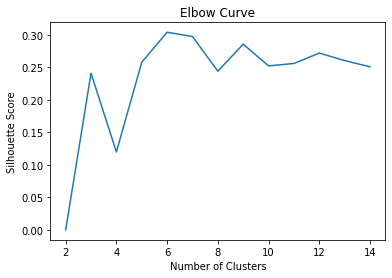

In [34]:
# PLOT the cosines

import pylab as pl
pl.plot(df_clusterSize.cluster, df_clusterSize.cosine)
pl.xlabel('Number of Clusters')
pl.ylabel('Silhouette Score')
pl.title('Elbow Curve')
pl.show()

In [ ]:
predictions.show()

+--------------------+--------------------+----------+
|                text|            features|prediction|
+--------------------+--------------------+----------+
|                text|[0.0,0.0,0.0,0.0,...|        12|
|Pfizer is looking...|[0.04806540875625...|         3|
|Pfizers COVID vac...|[0.50025610368800...|         2|
|pfizers¬†covidvac...|[0.0,0.0,0.0,0.0,...|        12|
|For more informat...|[0.05960954204242...|         3|
|CovidVaccine COVI...|[-0.2550230467739...|        12|
|One of  vaccines ...|[0.04421593534635...|         3|
|NVAX beats BNTX P...|[0.00450288041716...|         3|
|Though Pfizer use...|[-0.0505790027682...|        12|
|Phase III data on...|[0.15676166328007...|         3|
|PfizerBioNTech CO...|[0.06359193763152...|         3|
|So psyched  be pa...|[-0.0040071643692...|         3|
|BioNTech cofounde...|[0.04405919407265...|         3|
|Read  Aug 21 News...|[0.10173814900769...|         3|
|Read Carole Sians...|[0.04725395730151...|         3|
|PfizerBio

In [ ]:
predictions.filter("prediction=6").show(50, truncate=False)

+----------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|text                                                                                                            |features                                                                                                                                                                                                             |prediction|
+----------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------